In [20]:
import datetime
import polars as pl

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
txs = pl.scan_parquet('transactions/*.parquet')
blocks = pl.scan_parquet('blocks/*.parquet')

In [3]:
txs_blocks = (
    txs.join(blocks, on='block_number', how='left', suffix='_block')
    .with_columns([
        (pl.col('gas_used') * pl.col('gas_price') / 10**18).alias('tx_gas_cost'),
        pl.from_epoch('timestamp').alias('block_datetime'),
        pl.col('transaction_index').max().over(pl.col("block_number")).name.suffix("_max"),
        (pl.col('gas_price') / pl.col('base_fee_per_gas')).alias('block_gas_premium'),  # premium of the gas price over the base block gas fee
    ])
    .with_columns((pl.col('transaction_index') / pl.col('transaction_index_max') * 100).alias('blockspace_percentile'))
    .with_columns((pl.col("blockspace_percentile").round()).alias("rounded_blockspace_percentile")).fill_nan(0)
    .filter(pl.col('from_address') == '0xc1b634853cb333d3ad8663715b08f41a3aec47cc'.lower()) # Arbitrum: Batch Submitter
    .collect(streaming=True))

In [4]:
ordinals_spam_filter = txs_blocks.filter(pl.col('block_datetime') > datetime.datetime(2023,12,15))

In [5]:
ordinals_spam_filter.filter(pl.col('block_number') == 18792933).head(5)

# `gas_used_block` is the total gas used in the block. Max is 30m limit.
# if I add up gas_used, does that give me the total gas in the block per tx?

block_number,transaction_index,transaction_hash,nonce,from_address,to_address,value_binary,value_string,value_f64,gas_limit,gas_used,gas_price,transaction_type,max_priority_fee_per_gas,max_fee_per_gas,success,chain_id,block_hash,author,gas_used_block,extra_data,timestamp,base_fee_per_gas,chain_id_block,tx_gas_cost,block_datetime,transaction_index_max,block_gas_premium,blockspace_percentile,rounded_blockspace_percentile
u32,u64,str,u64,str,str,str,str,f64,u64,u64,u64,u32,u64,u64,bool,u64,str,str,u64,str,u32,u64,u64,f64,datetime[μs],u64,f64,f64,f64
18792933,5,"""0x8f05b6b2ff18ba3eef61eb6c1c618ba7dd5454fc017c65431ad708610ec5a5fc""",394304,"""0xc1b634853cb333d3ad8663715b08f41a3aec47cc""","""0x1c479675ad559dc151f6ec7ed3fbf8cee79582b6""","""0x0000000000000000000000000000000000000000000000000000000000000000""","""0""",0,1767449,1719016,143760080122,2,1100000000,148993446656,true,1,"""0x31acde3c5840a1355505567ababe9b12181405a0204b140556b19146643dbe83""","""0x6d2e03b7effeae98bd302a9f836d0d6ab0002766""",29975768,"""0x546974616e2028746974616e6275696c6465722e78797a29""",1702660475,142660080122,1,0.24712587789099993,2023-12-15 17:14:35,61,1.0077106363536268,8.19672131147541,8
18792933,6,"""0x47e2ab26e1b00cacbd8ec27127c0740a8294156015eef4c19b9e8039cc6c44f6""",394305,"""0xc1b634853cb333d3ad8663715b08f41a3aec47cc""","""0x1c479675ad559dc151f6ec7ed3fbf8cee79582b6""","""0x0000000000000000000000000000000000000000000000000000000000000000""","""0""",0,1838508,1790026,143235669910,2,1210000000,143235669910,true,1,"""0x31acde3c5840a1355505567ababe9b12181405a0204b140556b19146643dbe83""","""0x6d2e03b7effeae98bd302a9f836d0d6ab0002766""",29975768,"""0x546974616e2028746974616e6275696c6465722e78797a29""",1702660475,142660080122,1,0.2563955732663177,2023-12-15 17:14:35,61,1.0040346941310265,9.836065573770492,10
18792933,14,"""0xff8afcfcb91da3dcf166b3578b7db1999d5ad6b6889f10061046e285e8de59fa""",394306,"""0xc1b634853cb333d3ad8663715b08f41a3aec47cc""","""0x1c479675ad559dc151f6ec7ed3fbf8cee79582b6""","""0x0000000000000000000000000000000000000000000000000000000000000000""","""0""",0,1842808,1794323,142901444434,2,1210000000,142901444434,true,1,"""0x31acde3c5840a1355505567ababe9b12181405a0204b140556b19146643dbe83""","""0x6d2e03b7effeae98bd302a9f836d0d6ab0002766""",29975768,"""0x546974616e2028746974616e6275696c6465722e78797a29""",1702660475,142660080122,1,0.2564113484811482,2023-12-15 17:14:35,61,1.0016918840350684,22.950819672131146,23
18792933,15,"""0x72f5ad1f404d1c45acc0b98cc23aa579d838a96ddfbe1e723d3f15b5723dff3b""",394307,"""0xc1b634853cb333d3ad8663715b08f41a3aec47cc""","""0x1c479675ad559dc151f6ec7ed3fbf8cee79582b6""","""0x0000000000000000000000000000000000000000000000000000000000000000""","""0""",0,1828050,1779576,143870080122,2,1210000000,144055099704,true,1,"""0x31acde3c5840a1355505567ababe9b12181405a0204b140556b19146643dbe83""","""0x6d2e03b7effeae98bd302a9f836d0d6ab0002766""",29975768,"""0x546974616e2028746974616e6275696c6465722e78797a29""",1702660475,142660080122,1,0.25602774170318826,2023-12-15 17:14:35,61,1.0084816999889894,24.59016393442623,25
18792933,16,"""0x691287725bc0b766e70ec670baa3796412c803c17b6aa58602b3cd7acb3822a5""",394308,"""0xc1b634853cb333d3ad8663715b08f41a3aec47cc""","""0x1c479675ad559dc151f6ec7ed3fbf8cee79582b6""","""0x0000000000000000000000000000000000000000000000000000000000000000""","""0""",0,1794899,1746447,143760080122,2,1100000000,146715734431,true,1,"""0x31acde3c5840a1355505567ababe9b12181405a0204b140556b19146643dbe83""","""0x6d2e03b7effeae98bd302a9f836d0d6ab0002766""",29975768,"""0x546974616e2028746974616e6275696c6465722e78797a29""",1702660475,142660080122,1,0.2510693606488265,2023-12-15 17:14:35,61,1.0077106363536268,26.229508196721312,26


In [12]:
142660080122 / 10**9

142.660080122

In [17]:
ordinal_spam_stats_df = ordinals_spam_filter.group_by('block_number').agg(
    pl.col('block_datetime').first().alias('datetime'),
    (pl.col('base_fee_per_gas').first() / 10**9).alias('base_fee_per_gas_gwei'),
    pl.col('gas_used_block').first().alias('block_gas_used'),
    pl.col('gas_used').sum().alias('sequencer_gas_used_sum'),
    pl.col('transaction_index_max').first().alias('block_tx_size'),
    pl.count().alias('sequencer_tx_count')
    ).with_columns(
        (pl.col('sequencer_gas_used_sum') / pl.col('block_gas_used')).alias('seq_gas_block_percent'),
        (pl.col('sequencer_tx_count') / pl.col('block_tx_size')).alias('seq_tx_block_percent')
        ).sort(by='datetime', descending=True)

In [18]:
ordinal_spam_stats_df.head(5)

block_number,datetime,base_fee_per_gas_gwei,block_gas_used,sequencer_gas_used_sum,block_tx_size,sequencer_tx_count,seq_gas_block_percent,seq_tx_block_percent
u32,datetime[μs],f64,u64,u64,u64,u32,f64,f64
18794857,2023-12-15 23:43:23,53.023541371,16723178,1825264,142,1,0.10914576164889234,0.007042253521126761
18794856,2023-12-15 23:43:11,48.125302741,27213713,12872782,156,7,0.4730255661915741,0.04487179487179487
18794855,2023-12-15 23:42:59,46.477755769,19253769,9174659,119,5,0.47651236492969246,0.04201680672268908
18794854,2023-12-15 23:42:47,43.38273662,23561062,9071753,132,5,0.3850315830415454,0.03787878787878788
18794826,2023-12-15 23:36:59,48.294189173,20024434,3510104,139,2,0.1752910469279681,0.014388489208633094


In [ ]:
# 30,000,000/16 = 1.875 MB "30 million gas units"

<Axes: xlabel='block_number'>

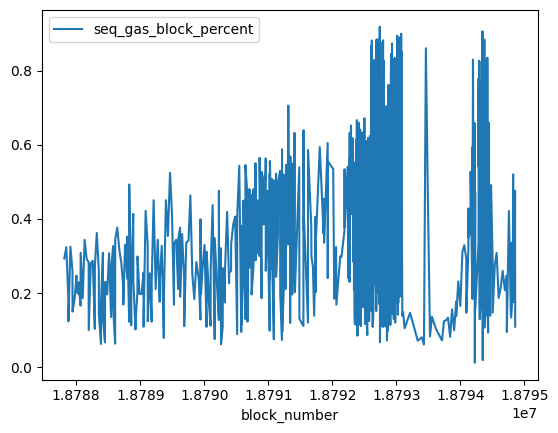

In [42]:
ordinal_spam_stats_df.to_pandas().plot(kind='line', x='block_number', y='seq_gas_block_percent')

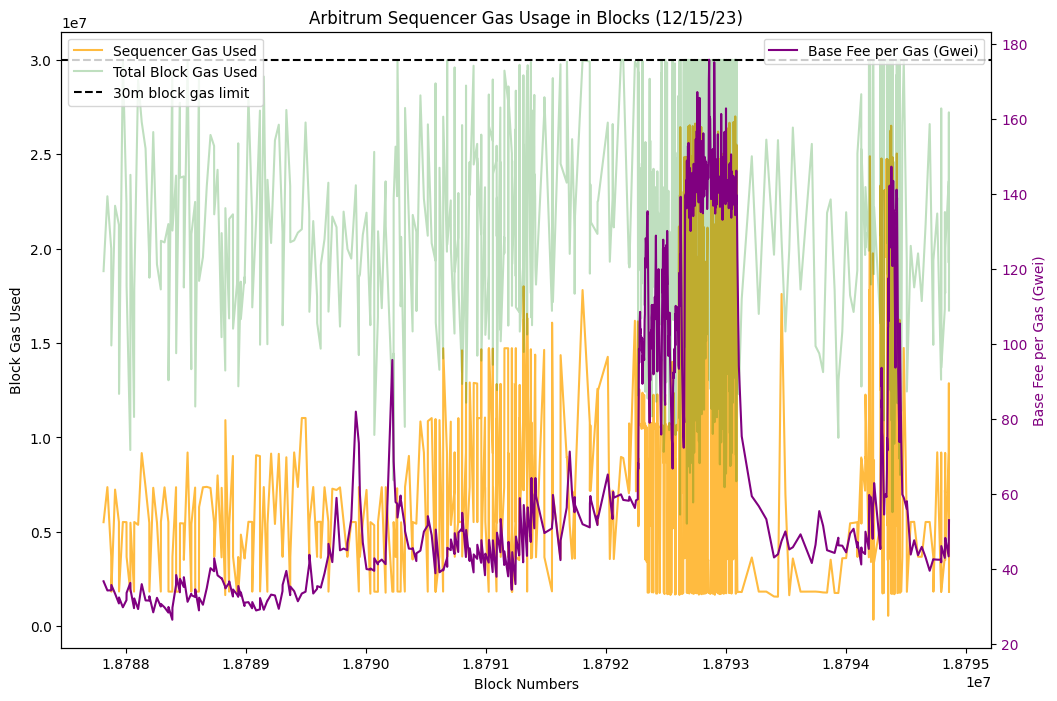

In [50]:
# Convert to pandas DataFrame (if not already)
plot_df = ordinal_spam_stats_df.to_pandas()

# Create a single plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot 'sequencer_gas_used_sum' and 'block_gas_used' on the first y-axis
ax1.plot(plot_df['block_number'], plot_df['sequencer_gas_used_sum'], label='Sequencer Gas Used', color='orange', alpha=0.75)
ax1.plot(plot_df['block_number'], plot_df['block_gas_used'], label='Total Block Gas Used', color='green', alpha=0.25)
ax1.axhline(y=3e7, color='black', linestyle='--', label='30m block gas limit')
ax1.set_xlabel('Block Numbers')
ax1.set_ylabel('Block Gas Used', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

# Create a twin y-axis for 'base_fee_per_gas_gwei'
ax2 = ax1.twinx()
ax2.plot(plot_df['block_number'], plot_df['base_fee_per_gas_gwei'], label='Base Fee per Gas (Gwei)', color='purple')
ax2.set_ylabel('Base Fee per Gas (Gwei)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.legend(loc='upper right')

# Title
plt.title('Arbitrum Sequencer Gas Usage in Blocks (12/15/23)')

# Show the plot
plt.show()